In [1]:
# elasticsearch related imports
import eland as ed
from elasticsearch import Elasticsearch, helpers
import requests
from requests.auth import HTTPBasicAuth

# data wrangling and visualization
from matplotlib import pylab as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn import metrics
import seaborn as sns
from IPython.display import Markdown, display

# other utils
import json
import pprint
import time

# Choosing the class assignment objective

---
#### TL;DR

* The default objective `maximize_minimum_recall` should work well for most cases.
* You should explicitly use the `maximize_minimum_recall` objective if you have an unbalanced data set and you are interested in high recall on the rare class.
* You should use the `maximize_accuracy` objective if you have a balanced data set and you are interested in high accuracy and precision.
---

When creating a classification analysis job in Elasticsearch, you can specify the [`class_assignment_objective`](https://www.elastic.co/guide/en/elasticsearch/reference/7.10/put-dfanalytics.html#ml-put-dfanalytics-request-body) using one of two parameters: `maximize_accuracy` and `maximize_minimum_recall`. Depending on your goal and your data set, you may prefer a different option. 

When evaluating results of a classification job one can be interested in one of three different metrics: [precision, recall, and accuracy](https://en.wikipedia.org/wiki/Precision_and_recall). Let's recap what they do, using an example of a test for a not further specified virus.  
- **Precision** is the fraction of relevant instances among the retrieved instances. Precision gives us two numbers: 
    1. What is the percentage of healthy people among those that were identified as "healthy" by the test and 
    2. What is the percentage of infected people among those that were identified as "infected" by the test.
- **Recall** is the fraction of relevant instances that were retrieved. Again, recall gives us two numbers: 
    1. What is the percentage of people identified as "healthy" by the test among all healthy people and 
    2. What is the percentage of people identified as "infected" among all infected people.
- **Accuracy** is the fraction of relevant instances among all instances. It gives us a single number: the percentage of correctly identified healthy and infected people among all tested people.

There is a trade-off between maximizing precision and recall. For example, labeling all people as "infected" will get us 100% but recall for infected people, since we identified all infected people in the sample, but only a very small precision since we misclassified many healthy people as "infected" as well.

Let's now look at how the different class assignment objectives `maximize_accuracy` and `maximize_minimum_recall` in Elasticsearch ML affect precision, recall, and accuracy on different synthetics data sets.

In [2]:
# Some general notebook setting
host = 'http://localhost:9200'
# IMPORTANT: create a file credentials.json with credentials for your Elasticsearch instance!
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']  
es = Elasticsearch(host, http_auth=(username, password))

def run_job(analysis_job_id: str, source_index: str, dest_index:str, class_assignment_objective:str):
    """Run a data frame analytics job to completion.

    Args:
      analysis_job_id (str): Base name of the analysis job
      source_index (str): Source index
      dest_index (str): Base name of the destination index
      class_assignment_objective (str): Class assignment objective. Can be 'maximize_accuracy' 
                                        or 'maximize_minimum_recall'
    """
    destination = "_".join([dest_index, class_assignment_objective])
    job_id = "_".join([analysis_job_id, class_assignment_objective])
    api = '/_ml/data_frame/analytics/{}'.format(job_id)
    config = {
      "description": "",
      "source": {
        "index": source_index,
        "query": {
          "match_all": {}
        }
      },
      "dest": {
        "index": destination,
        "results_field": "ml"
      },
      "analysis": {
        "classification": {
          "dependent_variable": "target",
          "training_percent": 85,
          "randomize_seed": 42,
            "class_assignment_objective": class_assignment_objective
        }
      },
      "model_memory_limit": "1gb",
      "max_num_threads": 1
    }
    requests.put(host+api, auth=HTTPBasicAuth(username, password),  json=config).json()

    api = "/_ml/data_frame/analytics/{}/_start".format(job_id)
    requests.post(host+api, auth=HTTPBasicAuth(username, password)).json()

    api = "/_ml/data_frame/analytics/{}/_stats".format(job_id)
    while True:
        results = requests.get(host+api, auth=HTTPBasicAuth(username, password),).json()
        state = results['data_frame_analytics'][0]['state']
        if state == 'stopped':
            break
        time.sleep(1)

def evaluate(dest_index: str, class_assignment_objective: str):
    """Evaluation prediction results form the data frame analytics job.
    
    Args:
      dest_index (str): Base name of the destination index
      class_assignment_objective (str): Class assignment objective. Can be 'maximize_accuracy' 
                                        or 'maximize_minimum_recall'
    """
    destination = "_".join([dest_index, class_assignment_objective])
    evaluate_train_config = {
      "index": destination, 
      "evaluation": {
        "classification": {
          "actual_field": "target", 
          "predicted_field": "ml.target_prediction",
          "metrics": {
            "accuracy": {},
            "precision": {},
            "recall": {}
          }
        }
      }
    }
    api = "/_ml/data_frame/_evaluate"
    results = requests.post(host+api, auth=HTTPBasicAuth(username, password), json=evaluate_train_config).json()
    return results

## Balanced classes

We begin by looking at a balanced classification data set where the number of data points for class 0 and class 1 are about the same. 

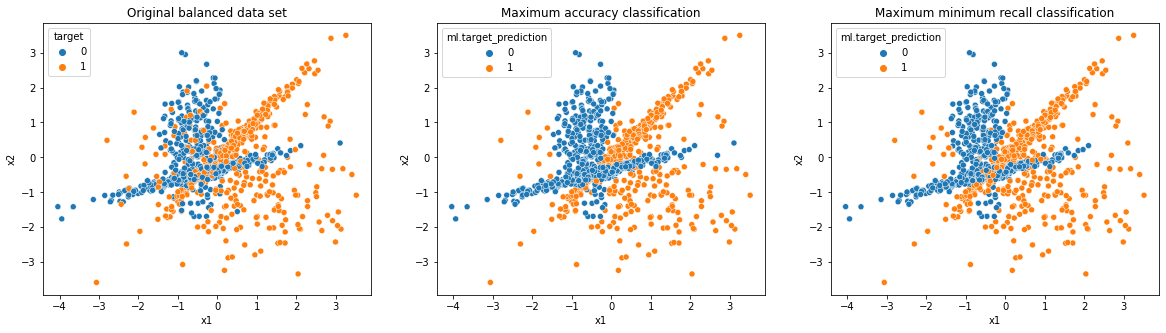

In [3]:
analysis_job_id = 'classification_balanced'
dest_index = 'classification_balanced_result'
source_index = 'classification_balanced'

X_balanced,y_balanced = make_classification(n_samples=1000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=0.5,flip_y=0,weights=[0.5,0.5], random_state=42)

balanced_pd_df = pd.DataFrame(X_balanced, columns=['x1','x2'])
balanced_pd_df['target'] = y_balanced

balanced_ed_df = ed.pandas_to_eland(pd_df=balanced_pd_df, es_client=es, 
                   es_dest_index=source_index, es_if_exists='replace',
                   es_refresh=True)

# train models with different class assignment objectives
run_job(analysis_job_id=analysis_job_id, source_index=source_index, 
        dest_index=dest_index, class_assignment_objective='maximize_accuracy')
run_job(analysis_job_id=analysis_job_id, source_index=source_index, 
        dest_index=dest_index, class_assignment_objective='maximize_minimum_recall')

# plot results
results_balanced_maxacc = ed.DataFrame(es_client=es, 
                                        es_index_pattern="_".join([dest_index, 'maximize_accuracy']), 
                       columns=['x1','x2','target','ml.target_prediction',
                                'ml.is_training', 'ml.prediction_probability', 'ml.prediction_score',
                               'ml.top_classes'])
results_balanced_maxminrecall = ed.DataFrame(es_client=es, 
                                              es_index_pattern="_".join([dest_index, 'maximize_minimum_recall']), 
                       columns=['x1','x2','target','ml.target_prediction',
                                'ml.is_training', 'ml.prediction_probability', 'ml.prediction_score',
                               'ml.top_classes'])

results_balanced_maxacc = ed.eland_to_pandas(results_balanced_maxacc)
results_balanced_maxminrecall = ed.eland_to_pandas(results_balanced_maxminrecall)

f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.scatterplot(x=balanced_pd_df['x1'], y=balanced_pd_df['x2'], 
                hue=balanced_pd_df['target'], ax=ax1)
ax1.set_title('Original balanced data set')
sns.scatterplot(x=results_balanced_maxacc['x1'], y=results_balanced_maxacc['x2'], 
                hue=results_balanced_maxacc['ml.target_prediction'], ax=ax2)
ax2.set_title('Maximum accuracy classification')
sns.scatterplot(x=results_balanced_maxminrecall['x1'], y=results_balanced_maxminrecall['x2'], 
                hue=results_balanced_maxminrecall['ml.target_prediction'], ax=ax3)
ax3.set_title('Maximum minimum recall classification')
plt.show()

Looking at the prediction results, we see that both class assignment objectives lead to qualitatively similar results.

In [4]:
display(Markdown("**Evaluation results for maximize_accuracy**"))

pprint.pprint(evaluate(dest_index=dest_index, class_assignment_objective='maximize_accuracy'))
display(Markdown("**Evaluation results for maximize_minimum_recall**"))
pprint.pprint(evaluate(dest_index=dest_index, class_assignment_objective='maximize_minimum_recall'))

**Evaluation results for maximize_accuracy**

{'classification': {'accuracy': {'classes': [{'class_name': '0',
                                              'value': 0.897},
                                             {'class_name': '1',
                                              'value': 0.897}],
                                 'overall_accuracy': 0.897},
                    'precision': {'avg_precision': 0.9029982255896768,
                                  'classes': [{'class_name': '0',
                                               'value': 0.8538324420677362},
                                              {'class_name': '1',
                                               'value': 0.9521640091116174}]},
                    'recall': {'avg_recall': 0.897,
                               'classes': [{'class_name': '0', 'value': 0.958},
                                           {'class_name': '1',
                                            'value': 0.836}]}}}


**Evaluation results for maximize_minimum_recall**

{'classification': {'accuracy': {'classes': [{'class_name': '0',
                                              'value': 0.903},
                                             {'class_name': '1',
                                              'value': 0.903}],
                                 'overall_accuracy': 0.903},
                    'precision': {'avg_precision': 0.903079003484683,
                                  'classes': [{'class_name': '0',
                                               'value': 0.9087221095334685},
                                              {'class_name': '1',
                                               'value': 0.8974358974358975}]},
                    'recall': {'avg_recall': 0.903,
                               'classes': [{'class_name': '0', 'value': 0.896},
                                           {'class_name': '1',
                                            'value': 0.91}]}}}


For **balanced** classes both class assignment objectives achieve comparable accuracy of 90.5% and 90.9%. 

For `maximize_accuracy` class assignment object a slight trade-off between classes (class 0 has a lower precision of 87% and higher recall of 95%, while the class 1 with precision 95% and recall 86%). 

For `maximize_minimum_recall` this trade-off is even smaller: class 0 precision 91% and recall 90%, class 1 precision 90% and recall 91%.

Therefore, for *classes data set with balanced classes both class assignment objectives would achieve comparable model performance*.

## Unbalanced classes

Let's now look at an unbalanced classification data set with 90% of data points from class 0 and 10% data points from class 1.

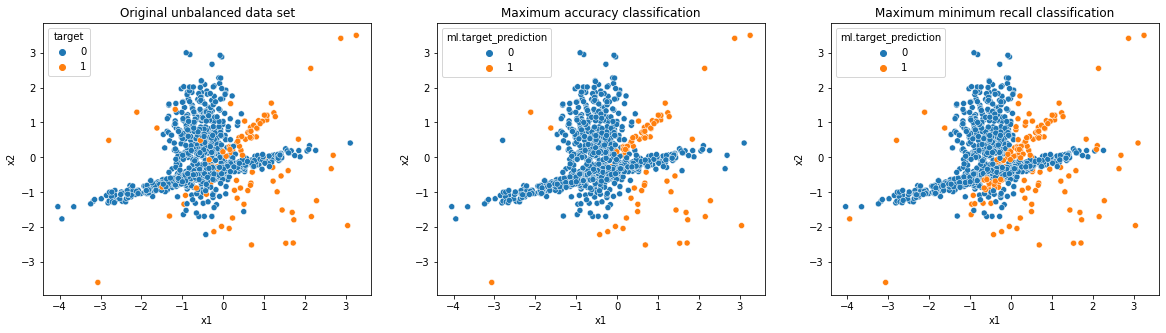

In [5]:
analysis_job_id = 'classification_unbalanced'
dest_index = 'classification_unbalanced_result'
source_index = 'classification_unbalanced'

X_unbalanced,y_unbalanced = make_classification(n_samples=1000, n_features=2, n_informative=2,
                          n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=0.5,flip_y=0,weights=[0.9,0.1], random_state=42)

unbalanced_pd_df = pd.DataFrame(X_unbalanced, columns=['x1','x2'])
unbalanced_pd_df['target'] = y_unbalanced

unbalanced_ed_df = ed.pandas_to_eland(pd_df=unbalanced_pd_df, es_client=es, 
                   es_dest_index=source_index, es_if_exists='replace',
                   es_refresh=True)

# train models with different class assignment objectives
run_job(analysis_job_id=analysis_job_id, source_index=source_index, 
        dest_index=dest_index, class_assignment_objective='maximize_accuracy')
run_job(analysis_job_id=analysis_job_id, source_index=source_index, 
        dest_index=dest_index, class_assignment_objective='maximize_minimum_recall')

# plot results
results_unbalanced_maxacc = ed.DataFrame(es_client=es, 
                                        es_index_pattern="_".join([dest_index, 'maximize_accuracy']), 
                       columns=['x1','x2','target','ml.target_prediction',
                                'ml.is_training', 'ml.prediction_probability', 'ml.prediction_score',
                               'ml.top_classes'])
results_unbalanced_maxminrecall = ed.DataFrame(es_client=es, 
                                              es_index_pattern="_".join([dest_index, 'maximize_minimum_recall']), 
                       columns=['x1','x2','target','ml.target_prediction',
                                'ml.is_training', 'ml.prediction_probability', 'ml.prediction_score',
                               'ml.top_classes'])

results_unbalanced_maxacc = ed.eland_to_pandas(results_unbalanced_maxacc)
results_unbalanced_maxminrecall = ed.eland_to_pandas(results_unbalanced_maxminrecall)

f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
sns.scatterplot(x=unbalanced_pd_df['x1'], y=unbalanced_pd_df['x2'], 
                hue=unbalanced_pd_df['target'], ax=ax1)
ax1.set_title('Original unbalanced data set')
sns.scatterplot(x=results_unbalanced_maxacc['x1'], y=results_unbalanced_maxacc['x2'], 
                hue=results_unbalanced_maxacc['ml.target_prediction'], ax=ax2)
ax2.set_title('Maximum accuracy classification')
sns.scatterplot(x=results_unbalanced_maxminrecall['x1'], y=results_unbalanced_maxminrecall['x2'], 
                hue=results_unbalanced_maxminrecall['ml.target_prediction'], ax=ax3)
ax3.set_title('Maximum minimum recall classification')
plt.show()

We see that results are qualitatively different. The model with the class assignment objective `maximize_accuracy` tends to predict most of the points as class 0 (blue). This misclassification is especially obvious for the individual data points outside of the "bulk" of the distribution. The model with the class assignment objective `maximize_minimum_recall` tends to predict those points correctly. However, it misclassified the class 0 points in the middle.

In [6]:
display(Markdown("**Evaluation results for maximize_accuracy**"))
pprint.pprint(evaluate(dest_index=dest_index, class_assignment_objective='maximize_accuracy'))

display(Markdown("**Evaluation results for maximize_accuracy**"))
pprint.pprint(evaluate(dest_index=dest_index, class_assignment_objective='maximize_minimum_recall'))

**Evaluation results for maximize_accuracy**

{'classification': {'accuracy': {'classes': [{'class_name': '0',
                                              'value': 0.963},
                                             {'class_name': '1',
                                              'value': 0.963}],
                                 'overall_accuracy': 0.963},
                    'precision': {'avg_precision': 0.9540699525462788,
                                  'classes': [{'class_name': '0',
                                               'value': 0.9644779332615716},
                                              {'class_name': '1',
                                               'value': 0.9436619718309859}]},
                    'recall': {'avg_recall': 0.8327777777777778,
                               'classes': [{'class_name': '0',
                                            'value': 0.9955555555555555},
                                           {'class_name': '1',
                                            'value': 0.67}

**Evaluation results for maximize_accuracy**

{'classification': {'accuracy': {'classes': [{'class_name': '0',
                                              'value': 0.928},
                                             {'class_name': '1',
                                              'value': 0.928}],
                                 'overall_accuracy': 0.928},
                    'precision': {'avg_precision': 0.7901353965183753,
                                  'classes': [{'class_name': '0',
                                               'value': 0.9893617021276596},
                                              {'class_name': '1',
                                               'value': 0.5909090909090909}]},
                    'recall': {'avg_recall': 0.92,
                               'classes': [{'class_name': '0', 'value': 0.93},
                                           {'class_name': '1',
                                            'value': 0.91}]}}}


For **unbalanced** data set, `maximize_accuracy` leads to a higher overall accuracy (96% vs. 90%). However, the recall for the class 1 is only 64%, since the model tends to classify most data points as class 0. For `maximize_minimum_recall` the recall of class 1 is 88%. The price that we pay is that now even some points from class 0 are classified as class 1 (class 1 precision of 51%).

So what is the difference between `maximize_accuracy` and `maximize_minimum_recall`? 

Strictly speaking, both parameters result in training the same decision forest. However, once the decision forest computes the `class_probability` for class 0 and class 1, the class assignment objective influences which class is predicted at the end: using class assignment objective, we compute `class_score` from `class_probability` and then pick the class with the higher `class_score`.

For `maximize_accuracy` we have `class_score`=`class_probability` so we simply take the class with the highest probability.

For `maximize_minimum_recall` we estimate a threshold $k$ using an optimization procedure and compute:
$$
\mbox{class_score}(\mbox{class 0}) = \left\{
\begin{eqnarray*} \\
    \frac{k}{1.0-k}\cdot \mbox{probability}(\mbox{class 0}) & \mbox{ if k < 0.5}, \\
    \mbox{probability}(\mbox{class 0}) & \mbox{ else.}
\end{eqnarray*}
\right.
$$
$$
\mbox{class_score}(\mbox{class 1}) = \left\{
\begin{eqnarray*} \\
    \mbox{probability}(\mbox{class 1}) & \mbox{ if k < 0.5}, \\
    \frac{1.0-k}{k}\cdot \mbox{probability}(\mbox{class 1}) & \mbox{ else.}
\end{eqnarray*}
\right.
$$

As a result, we would assign different classes for some data points especially from the minority class:

In [7]:
display(Markdown('**Maximize accuracy result:**'))
pprint.pprint(results_unbalanced_maxacc.iloc[26]['ml.top_classes'])
display(Markdown('**Maximize minimum recall result:**'))
pprint.pprint(results_unbalanced_maxminrecall.iloc[26]['ml.top_classes'])

**Maximize accuracy result:**

[{'class_name': 1,
  'class_probability': 0.5220394076515247,
  'class_score': 0.5220394076515247},
 {'class_name': 0,
  'class_probability': 0.4779605923484753,
  'class_score': 0.4779605923484753}]


**Maximize minimum recall result:**

[{'class_name': 1,
  'class_probability': 0.5220394076515247,
  'class_score': 0.5220394076515247},
 {'class_name': 0,
  'class_probability': 0.4779605923484753,
  'class_score': 0.058146396945193454}]


## Conclusions

We looked at how you can use the `class_assignment_objective` classification analysis parameter to signal to the model what is more important for you. Choosing the correct assignment objective is especially important if you deal with an unbalanced data set. Although we looked only at binary classification, these principles are directly applicable to the multi-class classification.